In [1]:
%load_ext autoreload
%autoreload 2

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/earthpulse/pytorch_eo/blob/master/examples/ucmerced.ipynb)

In this example we are going to train an image classifier with the [UCMerced](http://weegee.vision.ucmerced.edu/datasets/landuse.html) dataset.

In [2]:
from pytorch_eo.datasets import UCMercedLandUse

ds = UCMercedLandUse(batch_size=25, verbose=True) 

ds.setup()

/home/juan/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(


data already extracted !
Number of images: 2100
Training samples 1260
Validation samples 420
Test samples 420


In [3]:
ds.df

,image,label
0,data/UCMerced_LandUse/Images/agricultural/agri...,0
1,data/UCMerced_LandUse/Images/agricultural/agri...,0
2,data/UCMerced_LandUse/Images/agricultural/agri...,0
3,data/UCMerced_LandUse/Images/agricultural/agri...,0
4,data/UCMerced_LandUse/Images/agricultural/agri...,0
...,...,...
2095,data/UCMerced_LandUse/Images/tenniscourt/tenni...,20
2096,data/UCMerced_LandUse/Images/tenniscourt/tenni...,20
2097,data/UCMerced_LandUse/Images/tenniscourt/tenni...,20
2098,data/UCMerced_LandUse/Images/tenniscourt/tenni...,20


In [4]:
ds.num_classes, ds.classes

(21,
 ['agricultural',
  'airplane',
  'baseballdiamond',
  'beach',
  'buildings',
  'chaparral',
  'denseresidential',
  'forest',
  'freeway',
  'golfcourse',
  'harbor',
  'intersection',
  'mediumresidential',
  'mobilehomepark',
  'overpass',
  'parkinglot',
  'river',
  'runway',
  'sparseresidential',
  'storagetanks',
  'tenniscourt'])

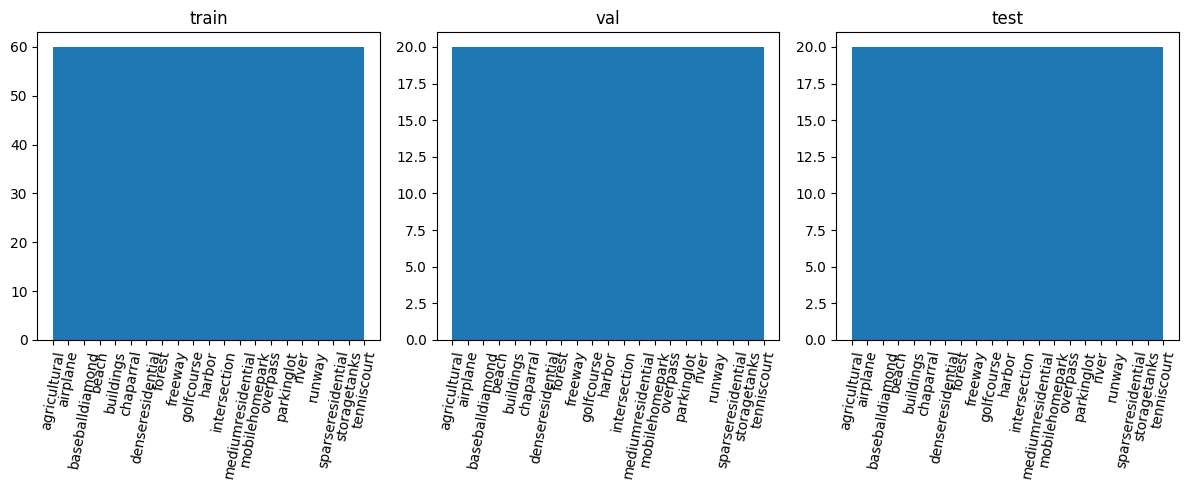

In [5]:
# label distribution

import numpy as np 
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))
ax = plt.subplot(1,3,1)
ax.hist(ds.train_df.label, bins=len(ds.classes))
ax.set_title('train')
ax.set_xticks(list(range(len(ds.classes))))
ax.set_xticklabels(ds.classes, rotation=80)
ax = plt.subplot(1,3,2)
ax.hist(ds.val_df.label, bins=len(ds.classes))
ax.set_title('val')
ax.set_xticks(list(range(len(ds.classes))))
ax.set_xticklabels(ds.classes, rotation=80)
ax = plt.subplot(1,3,3)
ax.hist(ds.test_df.label, bins=len(ds.classes))
ax.set_title('test')
ax.set_xticks(list(range(len(ds.classes))))
ax.set_xticklabels(ds.classes, rotation=80)
plt.tight_layout()
plt.show()

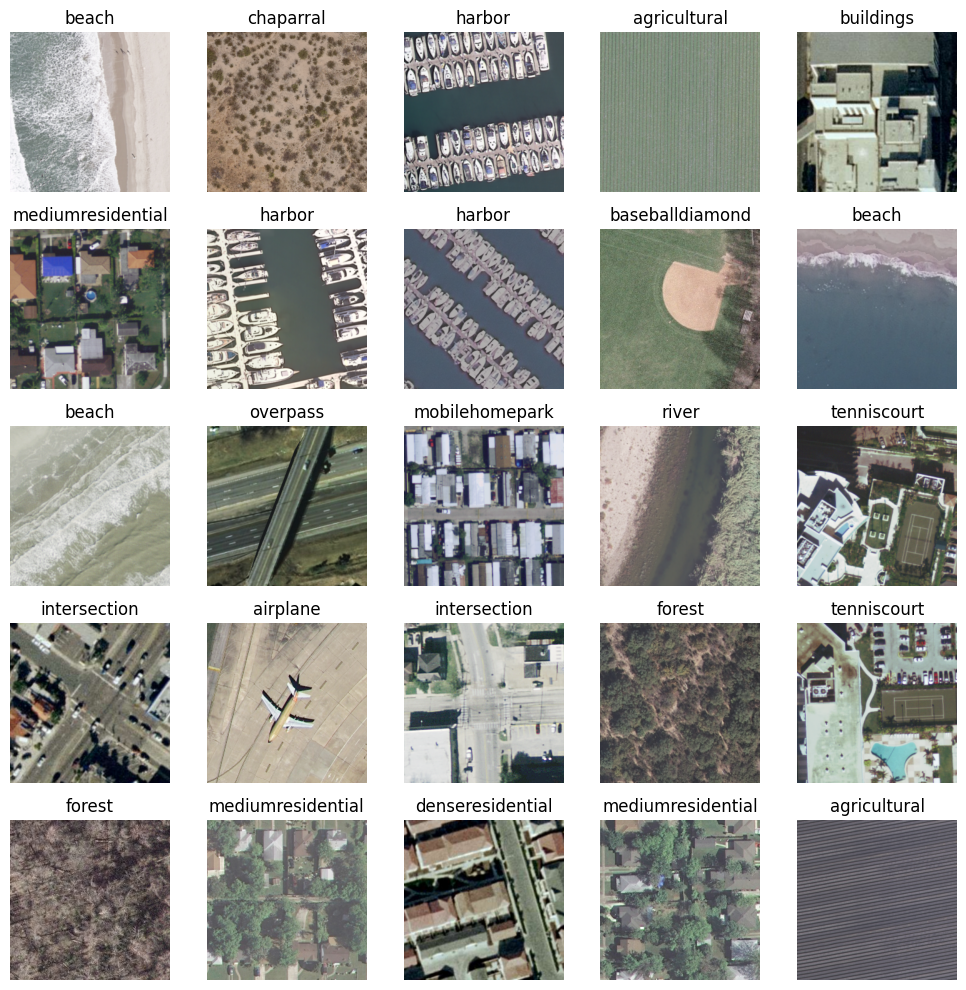

In [8]:
import matplotlib.pyplot as plt

batch = next(iter(ds.train_dataloader()))
imgs, labels = batch['image'], batch['label']

fig = plt.figure(figsize=(10, 10))
th = 4000
for i, (img, label) in enumerate(zip(imgs, labels)):
    ax = plt.subplot(5, 5, i + 1)
    ax.imshow(img)
    ax.set_title(ds.classes[label.item()])
    ax.axis('off')
plt.tight_layout()
plt.show()

Images are RGB with 256x256 pixels (although some have a different size, we'll need to fix it).

In [9]:
img.shape, img.dtype, img.min(), img.max()

(torch.Size([256, 256, 3]),
 torch.uint8,
 tensor(56, dtype=torch.uint8),
 tensor(146, dtype=torch.uint8))

Training

In [15]:
import pytorch_lightning as pl
from pytorch_eo.tasks.classification import ImageClassification
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision
import torch

train_trans = A.Compose([
    A.RandomCrop(224, 224),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.Transpose(),
    A.Normalize(0, 1),    
    ToTensorV2()                                
])

val_test_trans = A.Compose([
    A.CenterCrop(224, 224),
    A.Normalize(0, 1),    
    ToTensorV2()                                
])

ds = UCMercedLandUse(batch_size=64, train_trans=train_trans, val_trans=val_test_trans, test_trans=val_test_trans, num_workers=4, pin_memory=True)

model = torchvision.models.resnet18(weights='IMAGENET1K_V1')
model.fc = torch.nn.Linear(512, ds.num_classes)

task = ImageClassification(model)

In [16]:
trainer = pl.Trainer(
    gpus=1,
    max_epochs=10,
    log_every_n_steps=10
)

trainer.fit(task, ds)

/home/juan/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type             | Params
---------------------------------------------
0 | model   | ResNet           | 11.2 M
1 | loss

Epoch 9: 100%|██████████| 27/27 [00:01<00:00, 15.22it/s, loss=0.135, v_num=11, acc=1.000, val_loss=0.175, val_acc=0.950]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 27/27 [00:02<00:00, 13.24it/s, loss=0.135, v_num=11, acc=1.000, val_loss=0.175, val_acc=0.950]


In [17]:
trainer.test(dataloaders=ds.test_dataloader(), ckpt_path='last')

/home/juan/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:165: UserWarning: .test(ckpt_path="last") is set, but there is no fault tolerant or last checkpoint available. No checkpoint will be loaded.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 62.04it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9404761791229248
        test_loss           0.24179041385650635
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.24179041385650635, 'test_acc': 0.9404761791229248}]